# Matching Data

In this notebook, we demonstrate the MatchingData class, which organizes population data for matching, and some plotting tools for visualizing the data.

In [1]:
import logging 
logging.basicConfig(
    format="%(levelname)-4s [%(filename)s:%(lineno)d] %(message)s",
    level='INFO',
)

import pandas as pd

from pybalance import MatchingData, MatchingHeaders, split_target_pool, BetaBalance
from pybalance.genetic import GeneticMatcher
from pybalance.visualization import (
    plot_numeric_features, 
    plot_categoric_features, 
    plot_binary_features,
    plot_joint_numeric_distributions,
    plot_joint_numeric_categoric_distributions,
    plot_per_feature_loss
)

INFO [__init__.py:13] Loaded pybalance version 0.1.0.


## Initializing MatchingData

MatchingData can be initialized from either a string or pandas DataFrame.

In [2]:
data_path = '../../pybalance/sim/data/pool250000-target25000-normal0-lognormal0-binary4.parquet'
m = MatchingData(data=data_path)
m

,age,height,weight,gender,haircolor,country,population,binary_0,binary_1,binary_2,binary_3,patient_id
0,64.854093,189.466850,88.835049,1.0,1,4,pool,0,1,0,1,135740
1,52.571993,158.134940,94.215107,1.0,1,1,pool,0,1,0,1,49288
2,25.828361,154.692482,94.226222,1.0,0,3,pool,0,0,1,0,256676
3,70.177571,160.536632,94.244356,1.0,0,2,pool,0,0,0,1,338287
4,73.779164,153.551419,86.161814,0.0,0,1,pool,0,0,1,1,72849
...,...,...,...,...,...,...,...,...,...,...,...,...
274995,62.547794,186.005015,50.975051,0.0,0,1,target,0,0,1,1,579081
274996,69.879934,142.371386,100.138389,1.0,1,4,target,0,1,1,0,569939
274997,56.921402,130.639589,108.745182,1.0,1,5,target,0,1,0,0,532419
274998,34.082754,174.764051,67.998396,0.0,2,2,target,0,0,0,1,566266


In [3]:
data = pd.read_parquet(data_path)
m = MatchingData(data=data)
m

,age,height,weight,gender,haircolor,country,population,binary_0,binary_1,binary_2,binary_3,patient_id
0,64.854093,189.466850,88.835049,1.0,1,4,pool,0,1,0,1,135740
1,52.571993,158.134940,94.215107,1.0,1,1,pool,0,1,0,1,49288
2,25.828361,154.692482,94.226222,1.0,0,3,pool,0,0,1,0,256676
3,70.177571,160.536632,94.244356,1.0,0,2,pool,0,0,0,1,338287
4,73.779164,153.551419,86.161814,0.0,0,1,pool,0,0,1,1,72849
...,...,...,...,...,...,...,...,...,...,...,...,...
274995,62.547794,186.005015,50.975051,0.0,0,1,target,0,0,1,1,579081
274996,69.879934,142.371386,100.138389,1.0,1,4,target,0,1,1,0,569939
274997,56.921402,130.639589,108.745182,1.0,1,5,target,0,1,0,0,532419
274998,34.082754,174.764051,67.998396,0.0,2,2,target,0,0,0,1,566266


MatchingData will infer which covariates to use for matching and the separation of these into numeric and categoric, unless explicitly specified. Here we specify a subset of the covariates to use for matching. Note that the unused columns are still present in the data, but will simply not be used for matching.

In [4]:
headers = MatchingHeaders(
    categoric=['country', 'gender', 'binary_0', 'binary_1'],
    numeric=['age', 'weight', 'height']
)
m = MatchingData(
    data=data, 
    headers=headers
)
m

,age,height,weight,gender,haircolor,country,population,binary_0,binary_1,binary_2,binary_3,patient_id
0,64.854093,189.466850,88.835049,1.0,1,4,pool,0,1,0,1,135740
1,52.571993,158.134940,94.215107,1.0,1,1,pool,0,1,0,1,49288
2,25.828361,154.692482,94.226222,1.0,0,3,pool,0,0,1,0,256676
3,70.177571,160.536632,94.244356,1.0,0,2,pool,0,0,0,1,338287
4,73.779164,153.551419,86.161814,0.0,0,1,pool,0,0,1,1,72849
...,...,...,...,...,...,...,...,...,...,...,...,...
274995,62.547794,186.005015,50.975051,0.0,0,1,target,0,0,1,1,579081
274996,69.879934,142.371386,100.138389,1.0,1,4,target,0,1,1,0,569939
274997,56.921402,130.639589,108.745182,1.0,1,5,target,0,1,0,0,532419
274998,34.082754,174.764051,67.998396,0.0,2,2,target,0,0,0,1,566266


## Exploring MatchingData

The describe*() methods can be used to generate summary tables of the matching covariates.

In [5]:
m.describe(normalize=False)

pool    target
population size N       250000.00  25000.00
country         0            0.00   2490.00
                1        25033.00   5045.00
                2        49534.00   4981.00
                3        75337.00   2474.00
                4        74934.00   5010.00
                5        25162.00   5000.00
gender          0       120054.00  12956.00
                1       129946.00  12044.00
binary_0        0       225028.00  17535.00
                1        24972.00   7465.00
binary_1        0       175673.00  12527.00
                1        74327.00  12473.00
age             mean        55.27     48.33
                std         13.18     14.39
                min         18.01     18.01
                q25         46.38     37.29
                median      57.15     48.74
                q75         66.10     59.85
                max         75.00     75.00
weight          mean        88.30     82.25
                std         16.32     18.89
                min         50.00     50.00
                q25         76.39     66.14
                median      88.85     81.69
                q75        100.88     97.41
                max        120.00    120.00
height          mean       159.13    153.68
                std         19.84     16.45
                min        125.00    125.00
                q25        142.09    140.29
                median     158.74    152.75
                q75        175.87    165.95
                max        195.00    195.00

You can access fields on the underlying data similarly to how you would in pandas.

In [6]:
m[['population', 'gender']]

,population,gender
0,pool,1.0
1,pool,1.0
2,pool,1.0
3,pool,1.0
4,pool,0.0
...,...,...
274995,target,0.0
274996,target,1.0
274997,target,1.0
274998,target,0.0


In [7]:
m[m['gender'] == 0]

,age,height,weight,gender,haircolor,country,population,binary_0,binary_1,binary_2,binary_3,patient_id
4,73.779164,153.551419,86.161814,0.0,0,1,pool,0,0,1,1,72849
7,67.404918,132.383184,67.107753,0.0,0,5,pool,0,0,0,1,171211
11,61.489148,140.780034,73.662572,0.0,0,1,pool,0,0,0,1,20695
12,73.718093,133.743721,58.879321,0.0,1,4,pool,0,0,1,0,58718
13,70.707782,156.629048,70.681391,0.0,0,2,pool,0,1,1,1,352801
...,...,...,...,...,...,...,...,...,...,...,...,...
274990,19.063519,167.704149,59.876565,0.0,2,4,target,0,1,1,1,536365
274992,58.745450,146.747313,70.291448,0.0,2,4,target,0,0,0,1,535279
274993,55.736083,132.434020,92.264209,0.0,1,4,target,0,1,0,0,595582
274995,62.547794,186.005015,50.975051,0.0,0,1,target,0,0,1,1,579081


Often our matching data consists of exactly two populations, a reference population, 
which we call the "target" and a population to be matched, which we call the "pool". 
It is sometimes convenient to split these two populations and the function 
split_target_pool does just that. The function will assign the smaller population to the
target, unless explicitly given the name of the target population.

In [8]:
target, pool = split_target_pool(m)
target.head()

,age,height,weight,gender,haircolor,country,population,binary_0,binary_1,binary_2,binary_3,patient_id
250000,57.266010,159.759575,94.325267,0.0,1,4,target,0,1,0,1,512966
250001,53.152645,145.515410,95.988094,0.0,1,2,target,1,0,1,1,540606
250002,34.079212,166.272208,73.090671,0.0,1,2,target,0,0,1,1,578266
250003,45.494927,144.336677,96.678251,1.0,2,5,target,1,1,1,1,559858
250004,18.036012,174.843524,60.586475,0.0,1,2,target,1,1,0,1,588368


In [9]:
target, pool = split_target_pool(m, target_name='pool')
pool.head()

,age,height,weight,gender,haircolor,country,population,binary_0,binary_1,binary_2,binary_3,patient_id
250000,57.266010,159.759575,94.325267,0.0,1,4,target,0,1,0,1,512966
250001,53.152645,145.515410,95.988094,0.0,1,2,target,1,0,1,1,540606
250002,34.079212,166.272208,73.090671,0.0,1,2,target,0,0,1,1,578266
250003,45.494927,144.336677,96.678251,1.0,2,5,target,1,1,1,1,559858
250004,18.036012,174.843524,60.586475,0.0,1,2,target,1,1,0,1,588368


## Visualizing MatchingData

Some built-in tools help you get a quick visual snapshot of the data. Many of these plotting routines are thin wrappers around seaborn plotting routines with extra logic relevant to matching situations (e.g. where one of the populations is a reference population or where variables should be treated as numeric / categoric). In most cases, the user can pass along any keyword arguments that are understood by the underlying seaborn routine.

In [10]:
%matplotlib inline

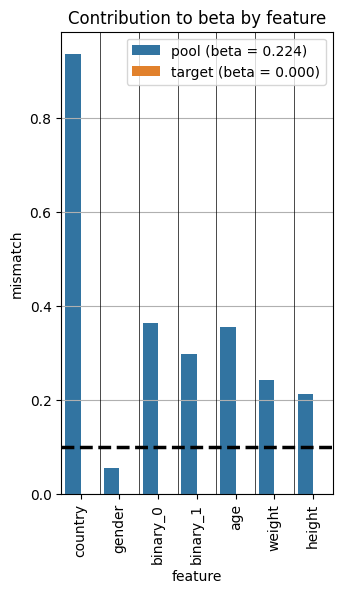

In [11]:
bc = BetaBalance(m)
fig = plot_per_feature_loss(m, bc)

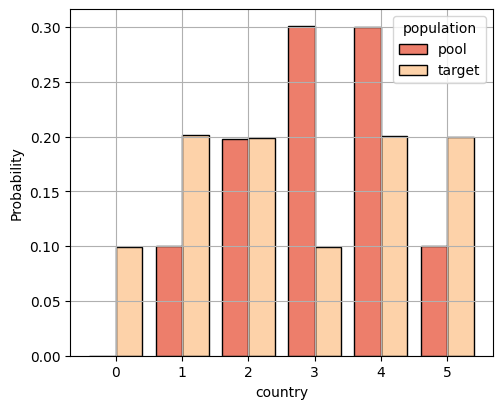

In [12]:
fig = plot_categoric_features(m, cumulative=False, palette='OrRd_r', include_binary=False)

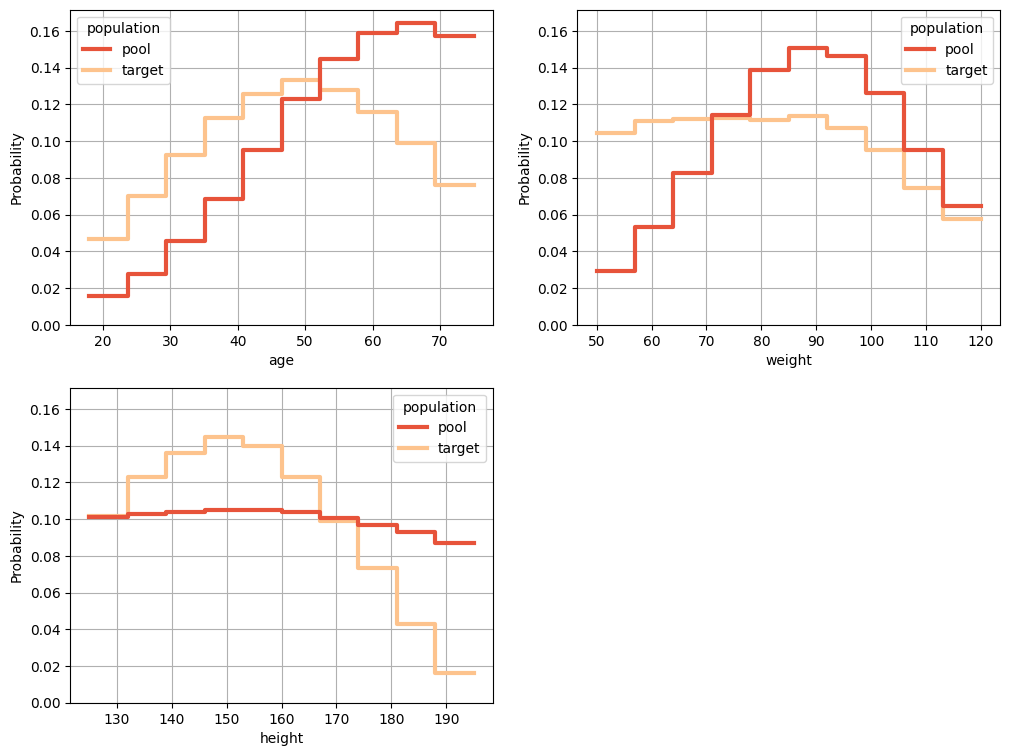

In [13]:
fig = plot_numeric_features(m, bins=10, cumulative=False, palette='OrRd_r')

/usr/local/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


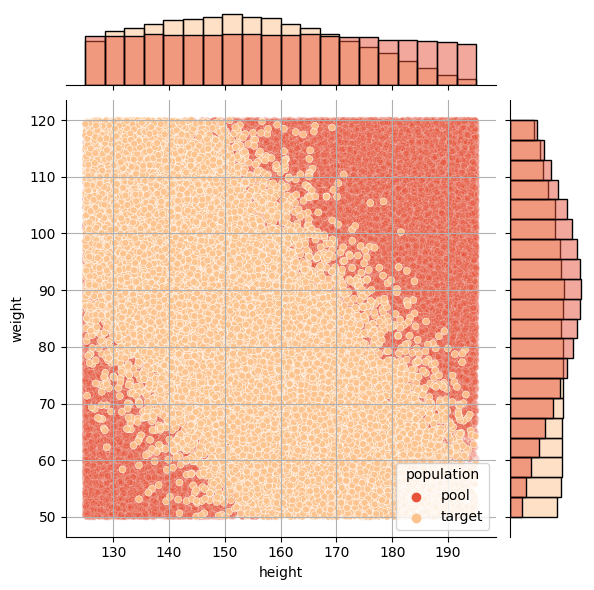

In [14]:
grids = plot_joint_numeric_distributions(m, include_only=['height', 'weight'], joint_kind='scatter', palette='OrRd_r')

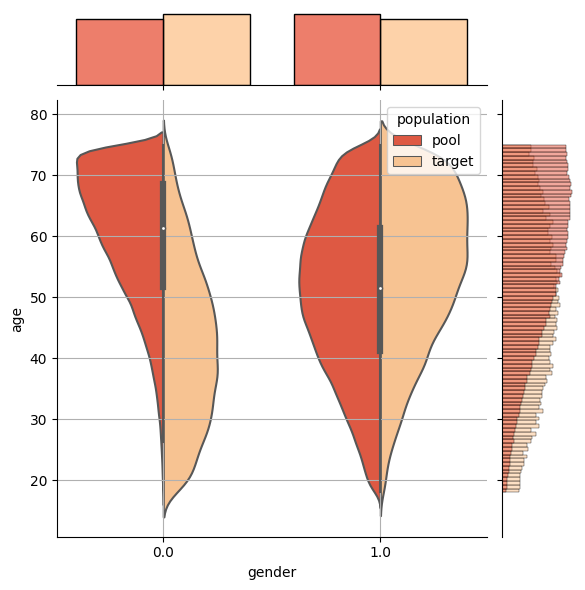

In [15]:
grids = plot_joint_numeric_categoric_distributions(
    m, 
    include_only_categoric=['gender'], 
    include_only_numeric=['age'], 
    palette='OrRd_r')